In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import os

c:\Users\ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


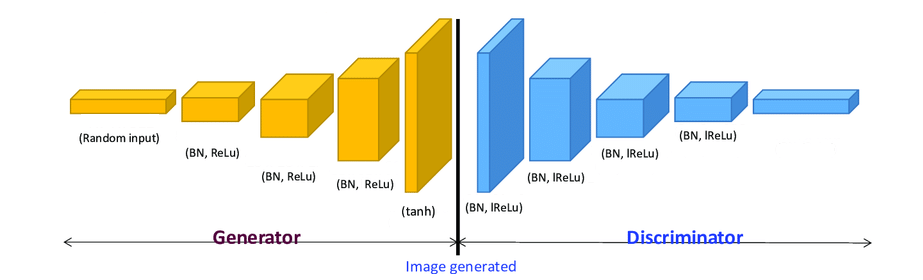

## Preprocessing

In [3]:
image_size = (128, 128)
batch_size = 128


transform = transforms.Compose([
    transforms.Resize(image_size),                                   # Resize images to the desired size
    transforms.CenterCrop(image_size),                               # Crop to center
    transforms.ToTensor(),                                           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = torchvision.datasets.ImageFolder('./images/', transform=transform)


# Calculate lengths for train, validation, and test sets
total_size = len(dataset)
train_size = round(0.8 * total_size)
valid_size = round(0.2 * total_size)
# testing is not logical here, if the images are good, then it passed the test!

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

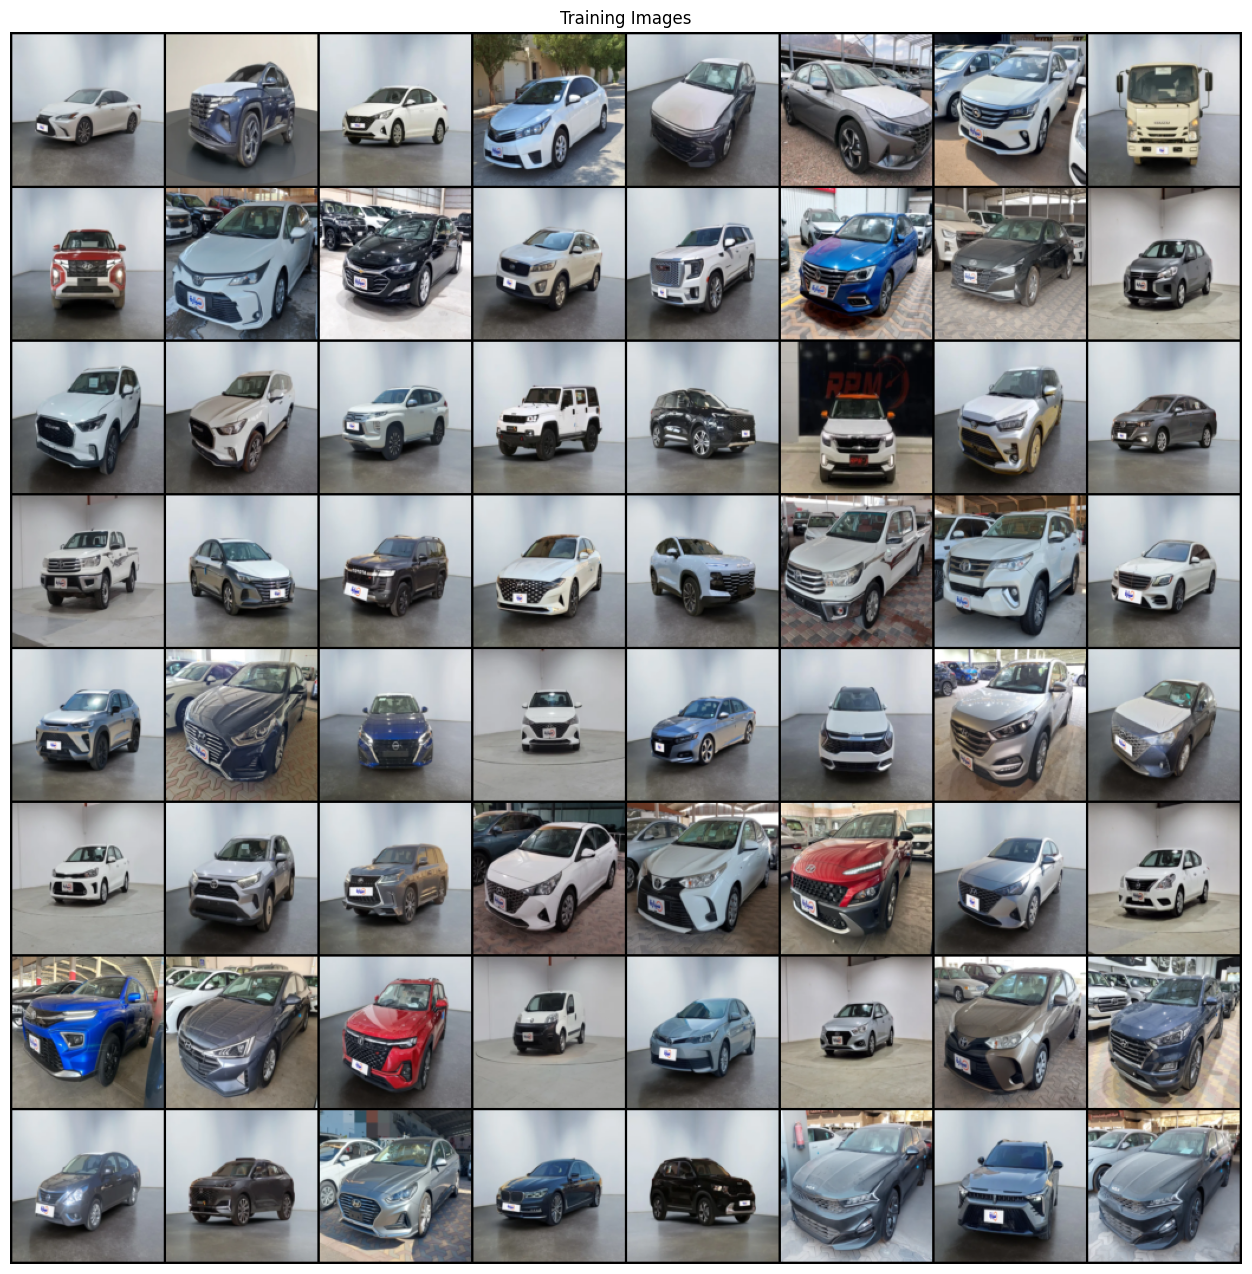

In [4]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model

In [5]:
def weights_init(m):
    """Initializes the weights to be in normal scale according to DCGAN Paper"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

---
## Generator & Discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, ngpu, ngf = 64, nc = 3): # nz -> laten
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     latent_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)
    

latent_size = 100  # Noise size to start generating fake cars

ngpu = 1
generator = Generator(100, ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
generator.apply(weights_init)

# Print the model
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim):
#         super(Generator, self).__init__()
#         self.latent_dim = latent_dim
#         self.image_size = 128
#         self.fc1 = nn.Linear(self.latent_dim, 128 * (self.image_size // 4) * (self.image_size // 4)) # First feature map
#         self.relu1 = nn.ReLU()
#         self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # Upsampling
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu2 = nn.ReLU()
#         self.deconv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
#         self.tanh = nn.Tanh()

#     def forward(self, latent):
#         # Expand the latent input to match batch size
#         latent = latent.view(latent.size(0), -1)

#         # Forward pass through the generator network
#         x = self.fc1(latent)
#         x = self.relu1(x)
#         x = x.view(x.size(0), 128, self.image_size // 4, self.image_size // 4)
#         x = self.deconv1(x)
#         x = self.bn1(x)
#         x = self.relu2(x)
#         x = self.deconv2(x)
#         x = self.tanh(x)  # Output in the range [-1, 1]
#         return x
    
    
# latent_size = 100  # Noise size to start generating fake cars
# generator = Generator(latent_size).to(device)
# generator.apply(weights_init)

# print(generator)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc = 3, ndf = 64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [10]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         # Define the layers for your discriminator network
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
#         self.relu1 = nn.LeakyReLU(0.2)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.relu2 = nn.LeakyReLU(0.2)
#         self.fc1 = nn.Linear(128 * 32 * 32, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Forward pass through the discriminator network
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = x.view(x.size(0), -1)  # Flatten the output
#         x = self.fc1(x)
#         x = self.sigmoid(x)
#         return x

    
# discriminator = Discriminator().to(device)
# discriminator.apply(weights_init)

# print(discriminator)

In [11]:
def load_fake_images(batch_size=batch_size, model=generator):

  # Generate a random latent vector
  noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

  # Generate a fake image using the generator
  fake_images = model(noise)
  
  return fake_images, torch.full((batch_size,), 0, device=device)


def load_real_images(batch_size=batch_size):
    images, labels = next(iter(train_loader))
    
    return images[:batch_size], torch.full((batch_size,), 1, device=device)

In [12]:
fake_images, fake_labels = load_fake_images()
real_images, real_labels = load_real_images()


print(f"Fake image shape: {fake_images.shape}\nReal image shape: {real_images.shape}")
print(f"Fake label shape: {fake_labels.shape}\nReal label shape: {real_labels.shape}")

Fake image shape: torch.Size([128, 3, 128, 128])
Real image shape: torch.Size([128, 3, 128, 128])
Fake label shape: torch.Size([128])
Real label shape: torch.Size([128])


In [13]:
def load_mixed_images(batch_size=64):

    # Batch size = 64, so load 32 of each subset
    real_images, real_labels = load_real_images(batch_size)
    fake_images, fake_labels = load_fake_images(batch_size, generator)
    
    real_images, real_labels, fake_images, fake_labels = real_images.to(device), real_labels.to(device), fake_images.to(device), fake_labels.to(device)
    # Combine the labels
    train_y = torch.cat((real_labels, fake_labels), dim=0)

    # Combine the real and fake data
    train_x = torch.cat((real_images, fake_images), dim=0)

    # Shuffle the combined data and labels
    indices = torch.randperm(len(train_x))
    shuffled_data = train_x[indices]
    shuffled_labels = train_y[indices]

    return shuffled_data, shuffled_labels

In [14]:
train_x, train_y = load_mixed_images(batch_size)

train_x.shape, train_y.shape

(torch.Size([256, 3, 128, 128]), torch.Size([256]))

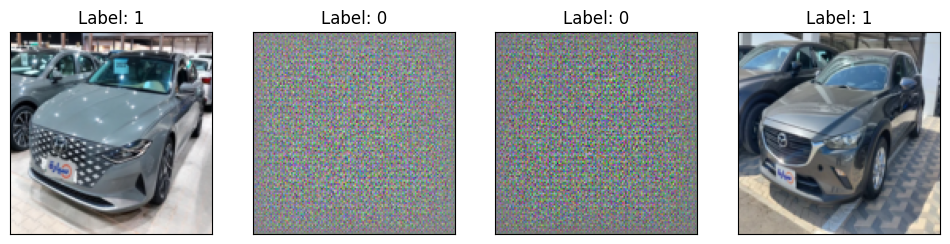

In [15]:
import matplotlib.pyplot as plt
import random

# Get a random sample of images from the dataset and their corresponding labels
num_samples = 4
sample_indices = random.sample(range(len(train_x)), num_samples)
sample_images = [train_x[i] for i in sample_indices]
sample_labels = [train_y[i] for i in sample_indices]

# Show the random images along with their labels
fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
for i, (axis, image_tensor, label) in enumerate(zip(axes, sample_images, sample_labels)):
    axis.set_xticks([])
    axis.set_yticks([])

    # Normalize the image data to the range [0, 1]
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())

    image_np = image_tensor.detach().cpu().numpy().transpose((1, 2, 0))
    axis.imshow(image_np)
    axis.set_title(f"Label: {label.item()}")

plt.show()

#### Save images function

In [16]:
from torchvision.utils import save_image
from datetime import datetime
def save_imgs(epoch, save_interval):
    noise = torch.randn(1, latent_size, 1, 1).to(device)
    gen_imgs = generator.forward(noise)
    os.makedirs("./saved_images", exist_ok=True)
    # Save generated images
    for i in range(len(gen_imgs)):
        image_path = f"./saved_images/epoch_{epoch}_{datetime.now().strftime('%m_%d_%H_%M_%S')}.png"
        save_image(gen_imgs[i], image_path)

---
## Training

In [17]:
def train_loop(train_loader, generator, discriminator, optimizer_G, optimizer_D, loss_fn):
    total_generator_loss = 0.0
    total_discriminator_loss = 0.0
    
    generator.train()
    discriminator.train()
    
    for images, _ in train_loader:
        # Train with real data
        optimizer_D.zero_grad()

        # Forward pass real images through Discriminator
        real_images = images
        outputs_real = discriminator(real_images.to(device)).view(-1)
        labels_real = torch.full((batch_size,), 1, device=device)
        loss_real = loss_fn(outputs_real, labels_real.float()).to(device)

        # Forward pass fake images through Discriminator
        fake_images, labels_fake = load_fake_images(model=generator)
        fake_images, labels_fake = fake_images.to(device), labels_fake.to(device)
        outputs_fake = discriminator(fake_images).view(-1)
        loss_fake = loss_fn(outputs_fake, labels_fake.float())

        # Calculate total loss and perform backprop
        discriminator_loss = loss_real + loss_fake
        discriminator_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        # Zero the gradients for the generator
        optimizer_G.zero_grad()

        # Generate fake images
        noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
        generated_images = generator(noise)

        # If discriminator says it is fake, then the loss is at max. Thus, enhancing the images every time.
        outputs = discriminator(generated_images).view(-1)
        # labels_generator = torch.ones(batch_size, 1).to(device)
        labels_generator = torch.full((batch_size,), 1, device=device)
        
        generator_loss = loss_fn(outputs, labels_generator.float())

        # Backpropagation
        generator_loss.backward()
        optimizer_G.step()

        # Keep track of loss for reporting
        total_generator_loss += generator_loss.item()
        total_discriminator_loss += discriminator_loss.item()

    return total_generator_loss / len(train_loader), total_discriminator_loss / len(train_loader)


def evaluate_loop(discriminator, generator, validation_loader, loss_fn):

    discriminator.eval()
    generator.eval()

    total_discriminator_loss = 0.0

    with torch.no_grad():
        for real_images, _ in validation_loader:
            batch_size = real_images.size(0)

            # Forward pass real images through Discriminator
            real_images = real_images.to(device)
            outputs_real = discriminator(real_images).view(-1)
            labels_real = torch.full((batch_size,), 1, device=device)
            
            loss_real = loss_fn(outputs_real, labels_real.float())

            # Generate fake images and forward pass through Discriminator
            fake_images, labels_fake = load_fake_images(model=generator)
            fake_images, labels_fake = fake_images.to(device), labels_fake.to(device)
            outputs_fake = discriminator(fake_images).view(-1)
            
            loss_fake = loss_fn(outputs_fake, labels_fake.float()).to(device)

            discriminator_loss = loss_real + loss_fake
            total_discriminator_loss += discriminator_loss.item()

    average_discriminator_loss = total_discriminator_loss / len(validation_loader)

    return average_discriminator_loss


def training(generator, discriminator, epochs, batch_size, optimizer_G, optimizer_D, loss_fn, train_loader, val_loader, verbose=True):
    best_acc = 0.0
    best_discriminator_loss = float('inf')

    for epoch in range(epochs):

        generator_loss, discriminator_loss = train_loop(train_loader, generator, discriminator, optimizer_G, optimizer_D, loss_fn)

        val_discriminator_loss = evaluate_loop(discriminator, generator, val_loader, loss_fn)
        
        
        if verbose and epoch % 5 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}]:")
            print(f"\tGenerator Loss: {generator_loss}")
            print(f"\tDiscriminator Loss: {discriminator_loss}")
            print(f"\n\tValidation Discriminator Loss: {val_discriminator_loss}")

        if epoch % 10 == 0: # Save the generator every 10 epochs
            save_imgs(epoch, 10)
            torch.save(generator.state_dict(), "generator.pth")
            torch.save(discriminator.state_dict(), "discriminator.pth")
        

In [20]:
loss_fn = nn.BCELoss()

# Creating models
generator = Generator(latent_size, ngpu).to(device)
discriminator = Discriminator(ngpu).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

if os.path.exists("generator.pth") and os.path.exists("discriminator.pth"):
    generator.load_state_dict(torch.load("generator.pth"))
    discriminator.load_state_dict(torch.load("discriminator.pth"))



optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=35e-5, betas=(0.5, 0.999))

training(generator, discriminator, 10000, batch_size, optimizer_G, optimizer_D, loss_fn, train_loader, valid_loader, verbose=True)

Epoch [1/10000]:
	Generator Loss: 51.28672807112984
	Discriminator Loss: 1.0233231508412335

	Validation Discriminator Loss: 0.1934000376611948
Epoch [6/10000]:
	Generator Loss: 60.6508321347444
	Discriminator Loss: 1.4922510809642715e-05

	Validation Discriminator Loss: 0.2577300176024437
Epoch [11/10000]:
	Generator Loss: 60.464912248694375
	Discriminator Loss: 8.719679087221266e-06

	Validation Discriminator Loss: 0.22922964245080948
Epoch [16/10000]:
	Generator Loss: 60.4462137636931
	Discriminator Loss: 9.221172661203045e-06

	Validation Discriminator Loss: 0.22512787580490112
Epoch [21/10000]:
	Generator Loss: 60.47613641490107
	Discriminator Loss: 2.7058395024110133e-06

	Validation Discriminator Loss: 0.2222780704498291
Epoch [26/10000]:
	Generator Loss: 60.49776475325875
	Discriminator Loss: 3.847839431467633e-06

	Validation Discriminator Loss: 0.21665272414684295


KeyboardInterrupt: 

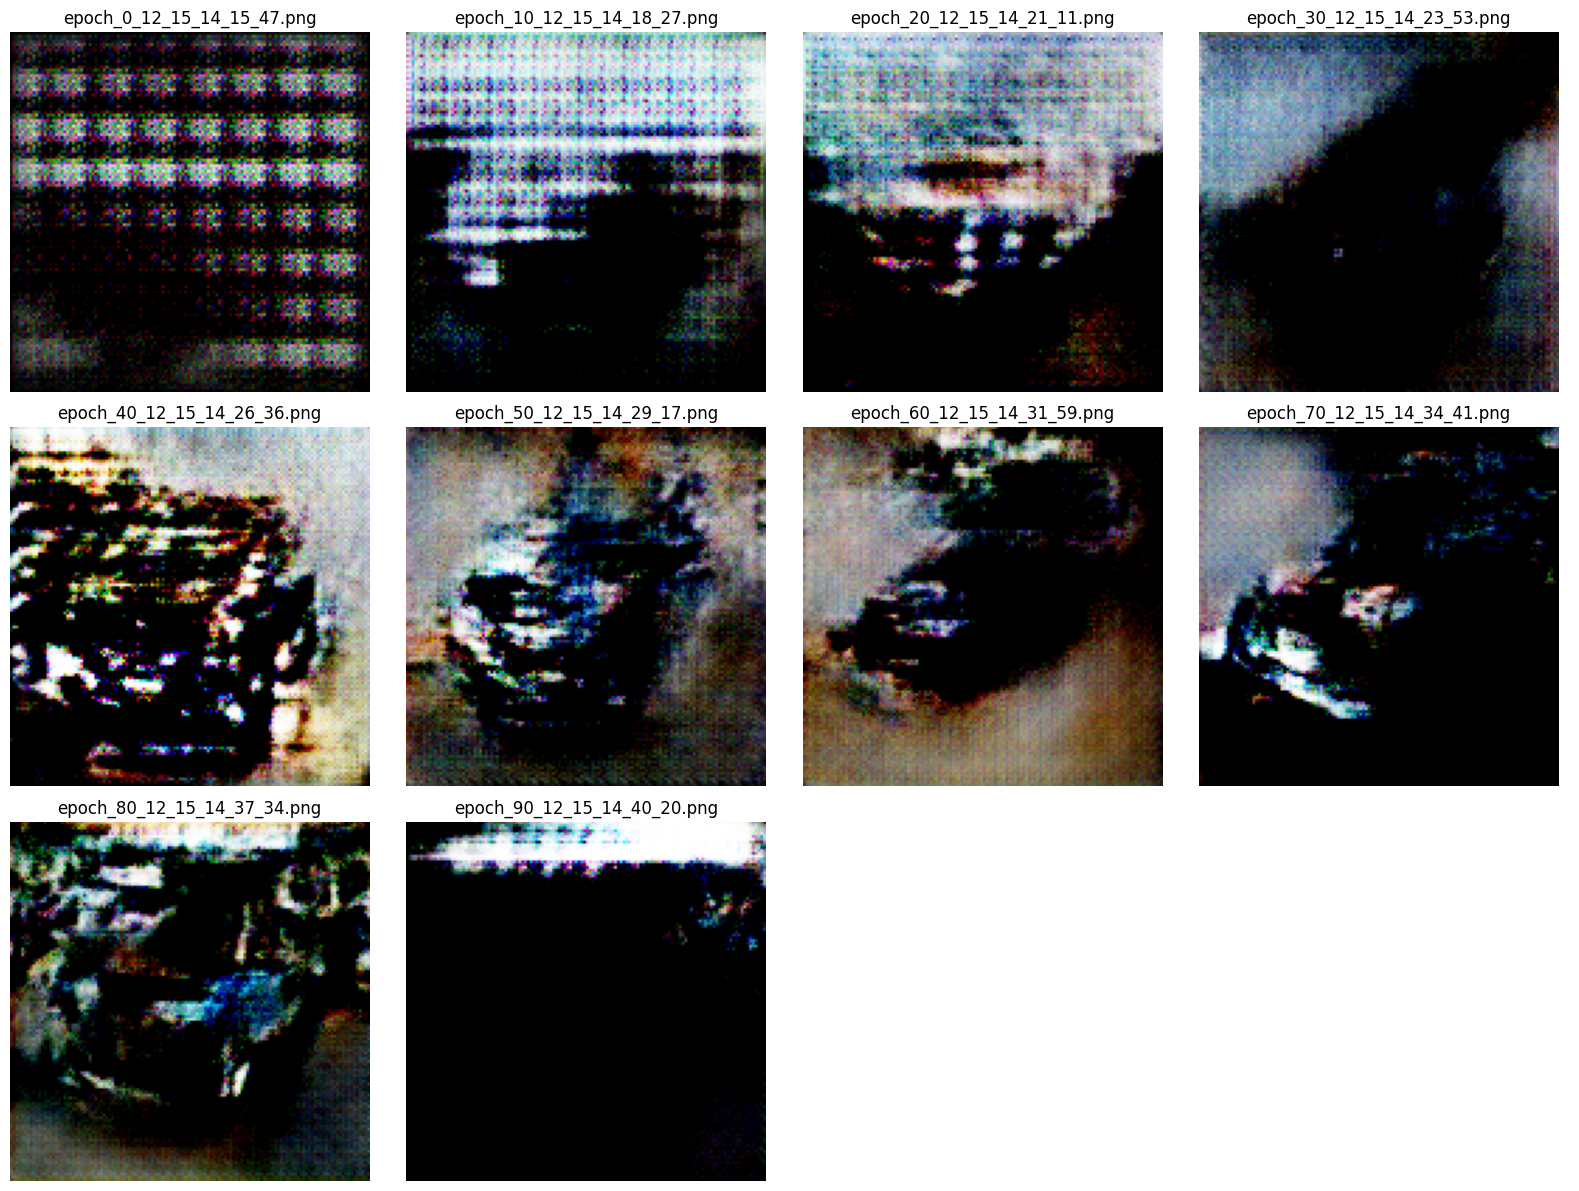

In [ ]:
files = [f for f in os.listdir('./saved_images')]

image_files = [f for f in files if f.lower().endswith(('.png'))]
image_files.sort()
row_size = 4
# Calculate number of rows needed
num_rows = len(image_files) // row_size + (1 if len(image_files) % row_size else 0)

# Create subplots
fig, axes = plt.subplots(num_rows, row_size, figsize=(row_size * 4, num_rows * 4))
axes = axes.flatten()

# Load and display each image
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join('./saved_images/', img_file)
    img = torchvision.io.read_image(img_path)
    ax.imshow(np.transpose(img.cpu().detach().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(img_file)

# Turn off unused axes
for ax in axes[len(image_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


---
# Testing

In [ ]:
#torch.manual_seed(1111111)
noise = torch.randn(4, latent_size).to(device)
fake_image = generator(noise)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(fake_image[i].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
    ax.axis("off")

plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [4, 100]